# ORC-CDMX data analisis v1.0.0#

26/05/2025:

Análisis de los datos adquiridos con la redpitaya.
Los archivos a analizar pueden tener la extensión .dat o .bz2.

Importo los modulos necesarios

In [ ]:
%matplotlib notebook
import bz2, os, time
from os import path
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats, interpolate
from scipy.optimize import curve_fit
import matplotlib.dates as mdate
from my_funcs import getfiles, natural_sort_key, cumsum_sma

Configuración y directorios. Los datos están en mi disco externo.

In [ ]:
NBINS    = 32  # 32 bines por pulso
ADCBITS  = 14  # 14 bits
TIME_SEP = 8e-9   # 8 ns por punto
BASELINE = 0   # linea de base

#data_dir= '/media/arnaldi/seagate4tb/git/lharnaldi/python_scripts/data_analisis/rp/lago/data/'
data_dir = 'data/' # Directorio donde se encuentran los datos
plot_dir = 'plot/' # Directorio donde se guardaran las graficas

#fname_prefix puede ser mon_hv,mon_hv_v2,spnk,spnk_v2
#fname_prefix = 'spnk'

#sadq,tepoch,clk_freq,r1,r2,tempi,pres,hv1,hv2,temp1,temp2 = np.loadtxt('{}_mtd_tot.bz2'.format(fname_prefix), unpack=1)
#cntri,tch,dt = np.loadtxt('{}_dt_tot.bz2'.format(fname_prefix), unpack=1)

### 0.- Channels
Gráficas de los pulsos en los canales adquiridos.

In [ ]:
N=5000 # Número de puntos a graficar

#filename = input('Ingrese el nombre del archivo (*.dat o *.bz2) a procesar : ')
#filename= 'nuclearexp2_nogps_2022_05_13_14h00.dat.bz2' # Nombre del archivo a graficar
#filename= 'nico_nogps_2022_05_23_23h00.dat.bz2'
filename= 't60_nogps_2022_06_02_00h00.dat.bz2'
ch1, ch2 = np.loadtxt(os.path.join(data_dir, filename), unpack=1, dtype=int)

<IPython.core.display.Javascript object>


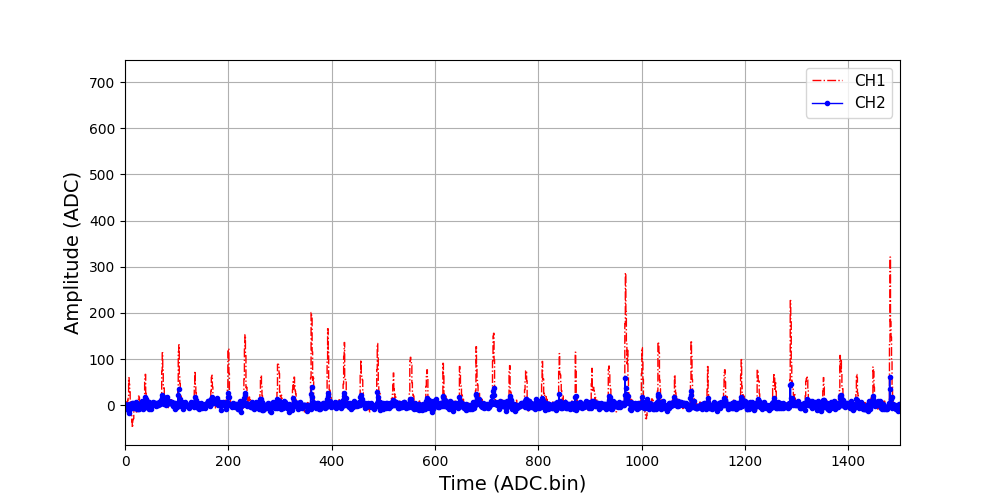

In [ ]:
x=np.linspace(0,N,N-1)
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

ax.step(x,ch1[:N-1], 'r-.',lw=1, label='CH1')
ax.step(x,ch2[:N-1], 'b.-',lw=1, label='CH2')

#ax.plot(ch1, 'r-o',lw=1, label='CH1')
#ax.plot(ch2, 'b.-',lw=1, label='CH2')

ax.legend(fontsize=11)
ax.grid()
ax.set_xlim(0,1500)
ax.set_ylabel('Amplitude (ADC)',fontsize=14)
ax.set_xlabel('Time (ADC.bin)',fontsize=14)

plt.savefig(os.path.join(plot_dir,'pulses_{}.png'.format(filename)))
#plt.show()

### 1.- Análisis de las baselines.
Se hace el fit con la función gaussiana  $A \cdot e^{\left(\frac{-(x-x_0)^2}{(2\cdot\sigma^2)}\right)}$

In [ ]:
#Para hacer el fit con una gaussiana, definimos la funcion
def gauss_function(x, a, x0, sigma):
        return a*np.exp(-(x-x0)**2/(2*sigma**2))

In [ ]:
#check if length is ok
ch1b=np.resize(ch1,ch1.size - len(ch1)%NBINS)
ch2b=np.resize(ch2,ch2.size - len(ch2)%NBINS)

bl1 = ch1b[0::NBINS]
bl2 = ch2b[0::NBINS]

In [ ]:
# En esta parte remuevo los datos que están más lejos de mean+-std*2
mean1=np.mean(bl1)
mean2=np.mean(bl2)
sd1=np.std(bl1)
sd2=np.std(bl2)

#bl1 = [x for x in bl1 if (x > mean1 - 3 * sd1)]
#bl2 = [x for x in bl2 if (x > mean2 - 3 * sd2)]
#bl1 = [x for x in bl1 if (x < mean1 + 3 * sd1)]
#bl2 = [x for x in bl2 if (x < mean2 + 3 * sd2)]

<IPython.core.display.Javascript object>


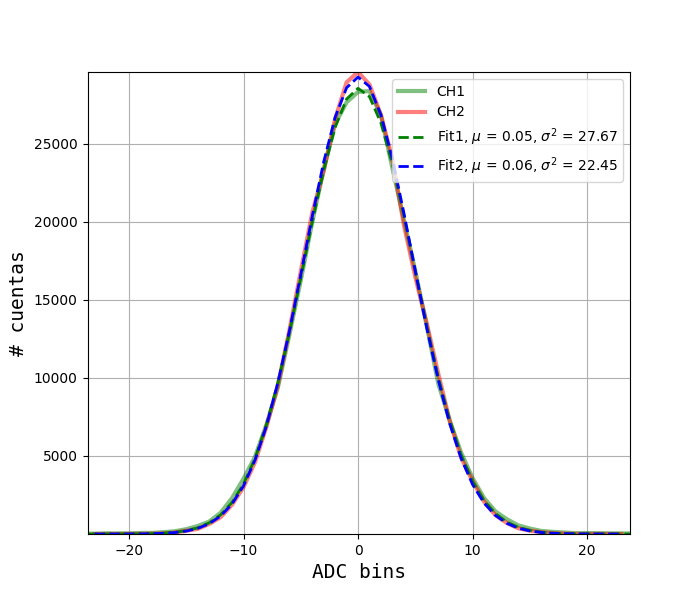

CH1: 0.05394980382674577 CH2: 0.06048411471601654
$A_1$ =  28563.6808574236 $x0_1 =$  0.06057929905576735 $\sigma_1$ =  -4.807060866816632
$A_2$ =  29284.31923608936 $x0_2 =$  0.030022032541925023 $\sigma_2$ =  4.7294131997199775


In [ ]:
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(7,6))
ax.grid()

#h1,bins1=np.histogram(bl1,bins=np.arange(min(bl1),max(bl1) + 1, 1),density=1)
#h2,bins2=np.histogram(bl2,bins=np.arange(min(bl2),max(bl2) + 1, 1),density=1)
h_bl1,b_bl1=np.histogram(bl1,bins=np.arange(min(bl1),max(bl1) + 1, 1))
h_bl2,b_bl2=np.histogram(bl2,bins=np.arange(min(bl2),max(bl2) + 1, 1))
popt1,pcov1 = curve_fit(gauss_function, b_bl1[:-1], h_bl1)
popt2,pcov2 = curve_fit(gauss_function, b_bl2[:-1], h_bl2)
#y1=stats.norm.pdf(bins1,np.mean(bl1),np.std(bl1))
#y2=stats.norm.pdf(bins2,np.mean(bl2),np.std(bl2))
#plt.clf()
ax.plot(b_bl1[:-1],h_bl1,'g',alpha=0.5,lw=3,label='CH1')
ax.plot(b_bl2[:-1],h_bl2,'r',alpha=0.5,lw=3,label='CH2')
ax.plot(b_bl1[:-1],gauss_function(b_bl1[:-1],*popt1),'g--',lw=2,label='Fit1, $\mu$ = %2.2f, $\sigma^2$ = %2.2f'%(np.mean(bl1),np.std(bl1)**2))
ax.plot(b_bl2[:-1],gauss_function(b_bl2[:-1],*popt2),'b--',lw=2,label='Fit2, $\mu$ = %2.2f, $\sigma^2$ = %2.2f'%(np.mean(bl2),np.std(bl2)**2))
#ax.plot(bins1,y1,'g--',lw=3,label='CH1, $\mu$ = %2.2f, $\sigma^2$ = %2.2f'%(np.mean(bl1),np.std(bl1)**2))
#ax.plot(bins2,y2,'b',lw=3,label='CH2, $\mu$ = %2.2f, $\sigma^2$ = %2.2f'%(np.mean(bl2),np.std(bl2)**2))
ax.axis([mean2-5*sd2, mean2+5*sd2,min(h_bl2),max(h_bl2)])
ax.set_xlabel('ADC bins',fontsize=14, fontname='monospace')
ax.set_ylabel('# cuentas',fontsize=14, fontname='monospace')
ax.legend()
print('CH1:',np.mean(bl1),'CH2:',np.mean(bl2))
plt.savefig(os.path.join(plot_dir,'bl_analisis.png'))
#plt.show()

#print(fr'$A_1$ = {popt1[0]}, $x0_1 =$ {popt1[1]}, $\sigma_1$ = {popt1[2]}')
print(r'$A_1$ = ',popt1[0], r'$x0_1 =$ ',popt1[1], r'$\sigma_1$ = ',popt1[2])
print(r'$A_2$ = ',popt2[0], r'$x0_2 =$ ',popt2[1], r'$\sigma_2$ = ',popt2[2])

### 2.- Histogramas de amplitud
Graficas de los histogramas de amplitud de los pulsos en los canales adquiridos.

In [ ]:
h_amp1,b_amp1=np.histogram(ch1,bins=np.arange(min(ch1),max(ch1) + 1, 1))
h_amp2,b_amp2=np.histogram(ch2,bins=np.arange(min(ch2),max(ch2) + 1, 1))

<IPython.core.display.Javascript object>


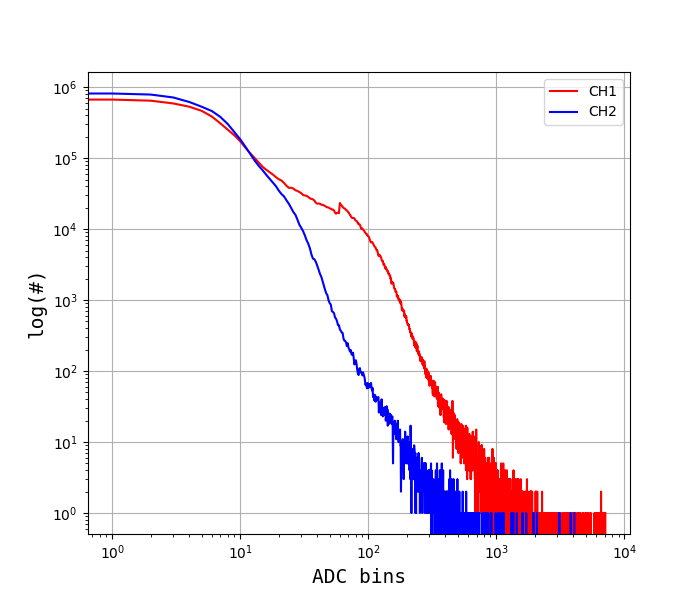

In [ ]:
fig, ax= plt.subplots(1, 1, figsize=(7, 6))
ax.grid()
#ax.semilogx(bins1[:-1],n1,bins2[:-1],n2)
ax.loglog(b_amp1[:-1],h_amp1, color='red', label='CH1')
ax.loglog(b_amp2[:-1],h_amp2, color='blue', label='CH2')
#ax.semilogy(b_amp1[:-1],h_amp1, color='red', label='CH1')
#ax.semilogy(b_amp2[:-1],h_amp2, color='blue', label='CH2')
#ax.plot(bins1[:-1],n1, color='red', lw=2, label='CH1')
#ax.plot(bins2[:-1],n2, color='blue', lw=2, label='CH2')
#ax.semilogx(hcar2.mean(axis=0), color='blue', lw=2, label='CH2')
ax.set_xlabel('ADC bins',fontsize=14, fontname='monospace')
ax.set_ylabel('log(#)',fontsize=14, fontname='monospace')
plt.legend()
#ax.set_ylim(1,0.8e4)
#ax.set_xlim(50,400)
# this is an inset axes over the main axes
#a = plt.axes([.65, .6, .2, .2], axisbg='y', alpha=0.02)
#a = plt.axes([.55, .55, .32, .32])
#a.loglog(hcar2.mean(axis=0), color='blue', lw=2, label='CH2')
#a.loglog(hcar2.mean(axis=0), color='blue', label='CH2')
#a.loglog(bins1[:-1],n1,bins2[:-1],n2,bins3[:-1],n3)
#a.loglog(bins2[:-1],n2, color='blue', lw=2, label='CH2')
#a.set_xlabel('Charge [ADC.bin]',fontsize=14, fontname='monospace')
#a.set_ylabel('Counts',fontsize=14, fontname='monospace')
#a.set_ylim(1,2e4)
#a.set_xlim(50,400)
#a.grid()
#plt.savefig('histo_peak.png')
plt.savefig(os.path.join(plot_dir,'amp_histo.png'))
#plt.show()

### 3.- Histogramas de carga


In [ ]:
BL1= np.mean(bl1) # baseline 1.
BL2= np.mean(bl2)  # baseline 2.

In [ ]:
#Areas
a1=np.array([int((ch1b[i:i+NBINS]-BL1).sum()) for i in np.arange(0,len(ch1b),NBINS)])
a2=np.array([int((ch2b[i:i+NBINS]-BL2).sum()) for i in np.arange(0,len(ch2b),NBINS)])
#Picos
p1=np.array([int((ch1b[i:i+NBINS]-BL1).max()) for i in np.arange(0,len(ch1b),NBINS)])
p2=np.array([int((ch2b[i:i+NBINS]-BL2).max()) for i in np.arange(0,len(ch2b),NBINS)])

In [ ]:
#print(len(a1),len(p1))
#print(p1[:10])

In [ ]:
#int((ch1b[0:0+NBINS]-BL1).max())

In [ ]:
#n1,bins1=np.histogram(a1,bins='auto',density=1)
#n2,bins2=np.histogram(a2,bins='auto',density=1)
#n1,bins1=np.histogram(a1,bins=np.arange(min(h1),max(h1) + 1, 1),density=1)
#n2,bins2=np.histogram(a2,bins=np.arange(min(h2),max(h2) + 1, 1),density=1)
h_car1,b_car1=np.histogram(a1,bins=np.arange(min(a1),max(a1) + 1, 1))
h_car2,b_car2=np.histogram(a2,bins=np.arange(min(a2),max(a2) + 1, 1))
#n1,bins1=np.histogram(a1,8192)
#n2,bins2=np.histogram(a2,8192)

<IPython.core.display.Javascript object>


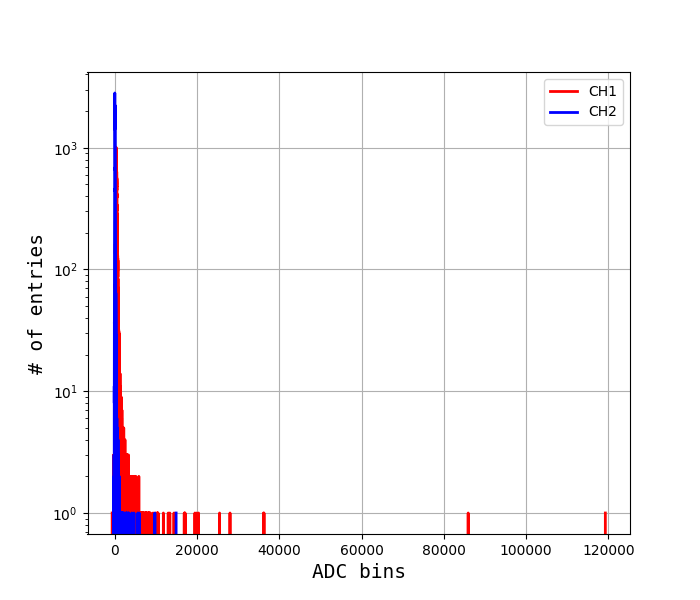

In [ ]:
fig, ax= plt.subplots(1, 1, figsize=(7, 6))
ax.grid()

#ax.loglog(b_car1[:-1],h_car1, color='red', lw=2, label='CH1')
#ax.loglog(b_car2[:-1],h_car2, color='blue', lw=2, label='CH2')
ax.semilogy(b_car1[:-1],h_car1, color='red', lw=2, label='CH1')
ax.semilogy(b_car2[:-1],h_car2, color='blue', lw=2, label='CH2')
ax.legend()

ax.set_xlabel('ADC bins',fontsize=14, fontname='monospace')
ax.set_ylabel('# of entries',fontsize=14, fontname='monospace')
#ax.set_ylim(1,0.8e4)
#ax.set_xlim(50,400)
# this is an inset axes over the main axes
#a = plt.axes([.65, .6, .2, .2], alpha=0.02)
#a = plt.axes([.55, .55, .32, .32])
##a.loglog(hcar2.mean(axis=0), color='blue', lw=2, label='CH2')
##a.loglog(hcar2.mean(axis=0), color='blue', label='CH2')
#a.semilogx(bins1[:-1],n1,bins2[:-1],n2)
#a.semilogx(bins2[:-1],n2, color='blue', lw=2, label='CH2')
##a.set_xlabel('Charge [ADC.bin]',fontsize=14, fontname='monospace')
##a.set_ylabel('Counts',fontsize=14, fontname='monospace')
##a.set_ylim(1,2e4)
##a.set_xlim(50,400)
#a.grid()
#plt.savefig('histo_carga.png')
plt.savefig(os.path.join(plot_dir,'charge_histo.pdf'))
#plt.show()

 ### Análisis de los metadatos.

 Se analiza todo un directorio con archivos adquiridos con la rp.

v 5

 This is a raw data file, version 1.0.0
 It contains the following data:
   <N1> <N2>        : line with values of the 2 ADC for a triggered pulse
   t <C> <V>      : end of a trigger
                      gives the channel trigger (<C>: 3 bit mask) and 125 MHz clock count (<V>) of the trigger time
    c <C>          : internal trigger counter
    r1 <V>         : pulse rate at channel 1
    r2 <V>         : pulse rate at channel 2
    x f <V>        : 125 MHz frequency
    x t <V>        : temperature value
    x p <V>        : pressure value
    x h <HH:MM:SS> <DD/MM/YYYY> <S> : GPS time (every new second, last number is seconds since EPOCH)
    x s <T> C <P> hPa <A> m : temperature <T>, pressure <P> and altitude (from pressure) <A>
    x g <LAT> <LON> <ALT>   : GPS data - latitude, longitude, altitude
    x v <HV1> <HV2>         : HV voltages for channels 1 and 2
    x b <B1> <B2> <B3>      : baselines (NOT IMPLEMENTED IN LAGO)
 In case of error, an unfinished line will be finished by # E @@@
 Followed by a line with # E <N> and the error message in human readable format, where <N> is the error code:
    E 1 : read timeout of 2 seconds
    E 2 : too many buffer reading tries
    E 3 : unknown word from FPGA

 Current registers setting

 x c T1 200
 x c T2 8190
 x c HV1 1799.7 mV
 x c HV2 7.7 mV
 x c SC1 1
 x c SC2 1
 This file was started on lago
 Machine local time was Thu Jan  1 20:11:11 1970
 WARNING, there is no GPS, using PC time

In [ ]:
dt      = np.array([])     #diferencias temporales
tch     = np.array([])     #trigger channel
cntri   = np.array([])     #contador interno de triggers
sadq    = np.array([])     #segundos de adquisicion - tiempo
clk_freq= np.array([])     #clock frequency
tempi   = np.array([])     #internal temperature
pres    = np.array([])     #internal presure
r1      = np.array([])     #rate 1
r2      = np.array([])     #rate 2
hv1     = np.array([])     #HV1
hv2     = np.array([])     #HV2
temp1   = np.array([])     #temperatura leida del sensor AD592 ch1
temp2   = np.array([])     #temperatura leida del sensor AD592 ch2
tepoch  = np.array([])     #tiempo epoch

In [ ]:
#thefile=bz2.BZ2File(os.path.join(data_dir, filename),"r")
#thefile=open(os.path.join(data_dir, filename),"r")
with bz2.open(os.path.join(data_dir,filename),mode='rt',encoding='utf-8') as thefile:
    for line in thefile:
        #sp = line.decode('utf-8').split()
        sp = line.split()
        if sp[0] == '#':
            #print(sp)
            if sp[1] == 't': #tiempos entre triggers
                tch = np.append(tch,int(sp[2]))
                dt  = np.append(dt,int(sp[3]))
            if sp[1] == 'c': #internal counter to check if we loose pulses
                cntri = np.append(cntri,int(sp[2]))

            if sp[1] == 'p':
                sadq = np.append(sadq,int(sp[2]))
                temp1 = np.append(temp1,float(sp[3]))
                temp2 = np.append(temp2,float(sp[4]))

            if sp[1] == 'x':
                if sp[2] == 'f': # x f <V>        : 125 MHz frequency
                    clk_freq = np.append(clk_freq,int(sp[3]))
                if sp[2] == 't': # x t <V>        : temperature value}
                    tempi = np.append(tempi,float(sp[3]))
                if sp[2] == 'p': # x p <V>        : pressure value
                    pres = np.append(pres,float(sp[3]))
                if sp[2] == 'h': # GPS data
                    tepoch = np.append(tepoch,int(sp[5]))
                    #print(line[9])
                    pass
                if sp[2] == 'v': # x v <HV1> <HV2>         : HV voltages for channels 1 and 2
                    hv1 = np.append(hv1,float(sp[3]))
                    hv2 = np.append(hv2,float(sp[4]))
            if sp[1] == 'r1': # x r1 <V>       : pulse rate at channel 1
                r1 = np.append(r1,int(sp[2]))
            if sp[1] == 'r2': # x r2 <V>       : pulse rate at channel 2
                r2 = np.append(r2,int(sp[2]))

#thefile.close()

In [ ]:
#print(len(a1),len(p1),len(dt))
#print([int(dt[i]*TIME_SEP*1e6) for i in range(10)])
#print(dt[:10])
#print(a1[:10]/p1[:10])

In [ ]:
#fig,ax=plt.subplots()
#plt.plot(dt%125e6)

### Gráfico de A/P vs dt

In [ ]:
ap_1 = np.array(a1/p1)
ap_2 = np.array(a2/p2)

<IPython.core.display.Javascript object>


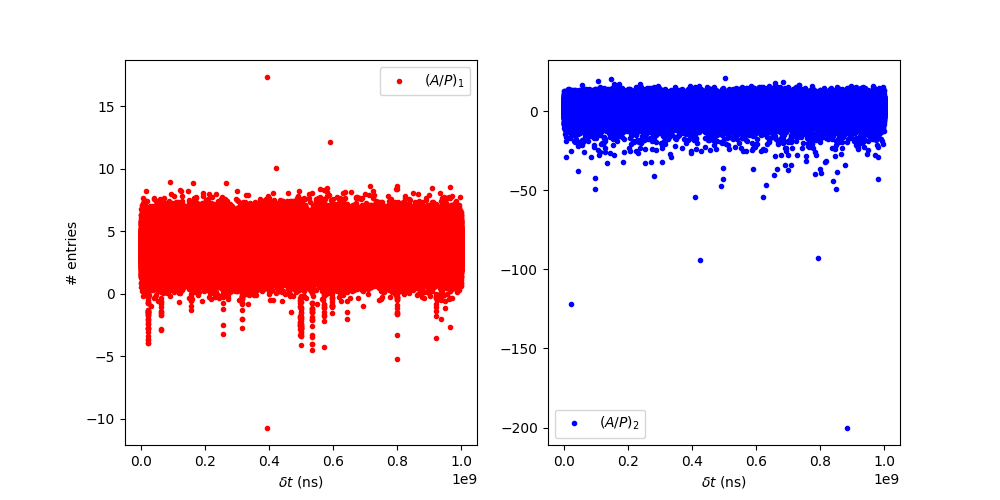

In [ ]:
fig,ax=plt.subplots(1,2,figsize=(10,5))
#h1,b1=np.histogram(p,bins=100,density=1)
#ax.semilogy(b1[:-1],h1,'r*',lw=2,label='Diferencia temporal')
#ax[0].plot([int(dt[i]*TIME_SEP*1e9) for i in range(len(dt))],a1/p1,'r.',label=r'$(A/P)_1$')
#ax[1].plot([int(dt[i]*TIME_SEP*1e9) for i in range(len(dt))],a2/p2,'b.',label=r'$(A/P)_2$')
ax[0].plot(dt*TIME_SEP*1e9,ap_1,'r.',label=r'$(A/P)_1$')
ax[1].plot(dt*TIME_SEP*1e9,ap_2,'b.',label=r'$(A/P)_2$')
#ax[1].plot(dt[:10]*TIME_SEP,a2[:10]/p2[:10],'b.',label=r'$(A/P)_2$')
#ax[1].plot(a2[:10]/p2[:10],dt[:10]*TIME_SEP, 'b.',label=r'$(A/P)_2$')
ax[0].legend()
ax[0].set_ylabel('# entries')
ax[0].set_xlabel(r'$\delta t$ (ns)')
ax[1].set_xlabel(r'$\delta t$ (ns)')
ax[1].legend()

Gráfico de diferencia temporal con dt

In [ ]:
#for i in range(1,11):
#    print(dt[i]-dt[i-1], dt[i]-dt[i-1]%125e6, (dt[i]-dt[i-1]%125e6)*TIME_SEP)

In [ ]:
#p=[((dt[i]-dt[i-1])%125e6)*TIME_SEP*1e9 for i in range(1,len(dt)-1)]
#fig,ax=plt.subplots(figsize=(7,6))
#ax.plot(p)

### Análisis de la vida media del muón
Prueba para ver si es posible hacer el cálculo de la vida media del muón con los datos.
Hago el histograma de diferencia temporal de todos los datos. Este histograma debe seguir la distribución de Poisson.

Para empezar, hacemos un fit con los datos para obtener el $\tau$ de esta distribución. El valor del parámetro B estará normalmente en torno a los ~ 150, lo que nos entrega un $\tau \simeq 6.4$ ms. ¿De qué depende este valor?

Para empezar, definimos la función con la cual vamos a hacer el fit. Esta es una función exponenciasl de la forma $A e^{-Bt} + C$, donde $\frac{1}{B} = \tau$.

In [ ]:
def func(t, A, B, C):
    """Modelo para nuestros datos."""
    return A * np.exp(-t*B) + C

In [ ]:
delta_t=[((dt[i]-dt[i-1])%125e6)*TIME_SEP for i in range(1,len(dt)-1)]

<IPython.core.display.Javascript object>


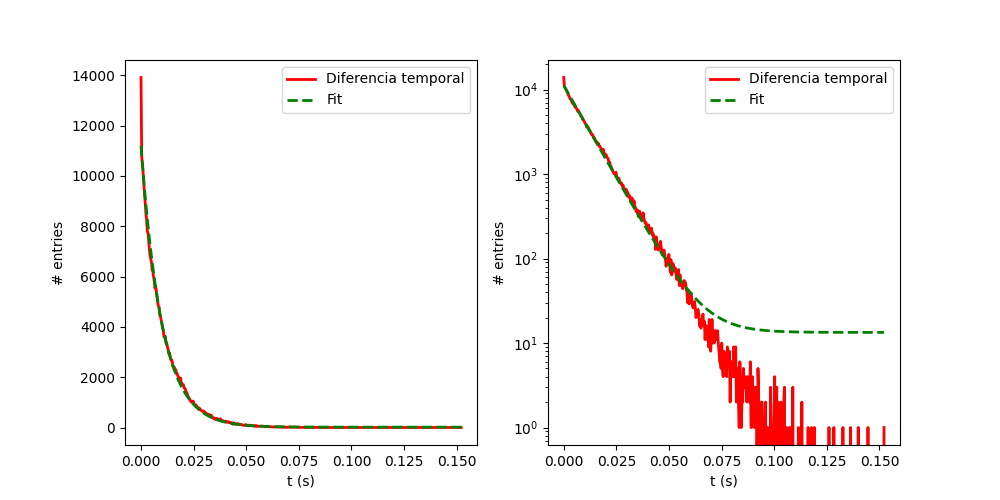

11186.220492670496 100.76441143852944 13.356753473981305
tau = 9.92 ms


In [ ]:
h_dt,b_dt=np.histogram(delta_t,bins='auto')
popt,pcov = curve_fit(func, b_dt[:-1], h_dt)

fig,ax=plt.subplots(1,2,figsize=(10,5))
#ax.semilogy(b1[:-1],h1,'r*',lw=2,label='Diferencia temporal')
ax[0].plot(b_dt[:-1],h_dt,'r-',lw=2,label='Diferencia temporal')
ax[0].plot(b_dt[:-1],func(b_dt[:-1],*popt),'g--',lw=2,label='Fit')
ax[0].set_ylabel('# entries')
ax[0].set_xlabel('t (s)')
ax[0].legend()

#fig,ax=plt.subplots(figsize=(7,6))
#ax.semilogy(b1[:-1],h1,'r*',lw=2,label='Diferencia temporal')
ax[1].semilogy(b_dt[:-1],h_dt,'r-',lw=2,label='Diferencia temporal')
ax[1].semilogy(b_dt[:-1],func(b_dt[:-1],*popt),'g--',lw=2,label='Fit')
ax[1].set_ylabel('# entries')
ax[1].set_xlabel('t (s)')
ax[1].legend()

print(popt[0], popt[1], popt[2])
print('tau = {:2.2f} ms'.format((1/popt[1])*1e3))

Bien, ahora lo que queda es limpiar un poco nuestros datos para poder observar el decaimiento del muón. Para eso, nos concentramos en los tiempos cortos, es decir diferencias temporales entre pulsos en torno a los 10 us.
Lo que se ve en el siguiente gráfico tiene que ver con las señales de ruido que están incorporadas a nuestros datos y el pico en torno a los ~6 u ~8 us tiene que ver con los afterpulses producidos dentro del PMT. Este último pico nos da información sobre el tamaño del PMT y si es nuevo o viejo, entre otras cosas.

In [ ]:
delta_t=[((dt[i]-dt[i-1])%125e6)*TIME_SEP*1e9 for i in range(1,len(dt)-1)]

<IPython.core.display.Javascript object>


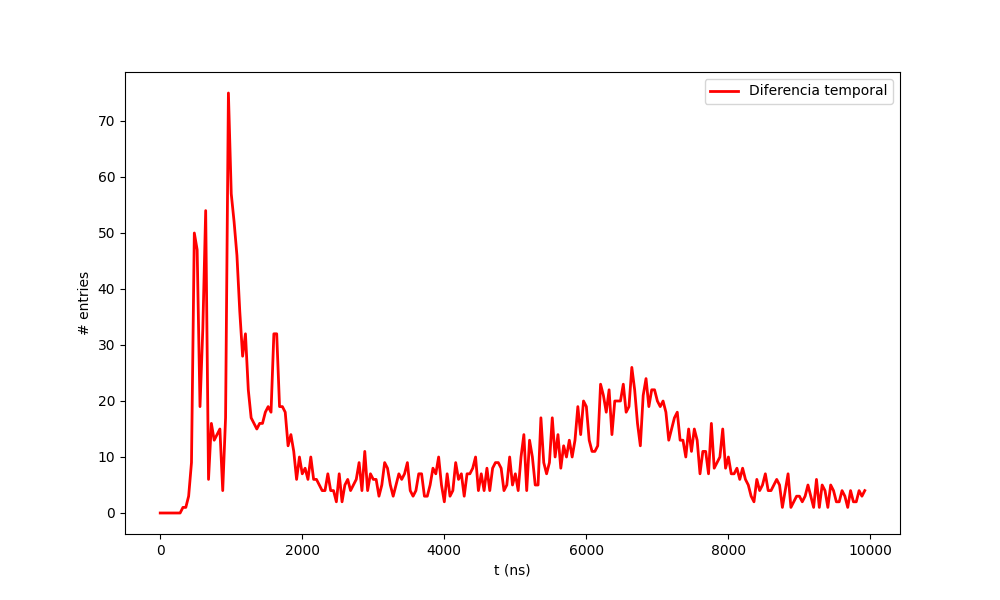

In [ ]:
delta_t=np.array(delta_t)
delta_t2=delta_t[delta_t<10000]
#h1,b1=np.histogram(p,bins=100,density=1)
h_dt2,b_dt2=np.histogram(delta_t2,bins=np.arange(1,10000,5*8))
#h_dt2,b_dt2=np.histogram(delta_t2,bins='auto')
fig,ax=plt.subplots(figsize=(10,6))

#ax.semilogy(b1[:-1],h1,'r*',lw=2,label='Diferencia temporal')
ax.plot(b_dt2[:-1],h_dt2,'r-',lw=2,label='Diferencia temporal')
ax.set_ylabel('# entries')
ax.set_xlabel('t (ns)')
#plt.yscale('log')
ax.legend()

#plt.show()

Ahora me quedo solamente con aquellos pulsos tales que A/P > 1.75. Esto lo hacemos para sacarnos de encima las señales espúreas que se ven al principio del histograma (ruido, fuentes switching, etc.).

In [ ]:
ap_clean = np.array([i for i in ap_1 if i > 3])
inds = np.where(ap_1 > 3)
dt_clean=dt[inds[0]]
#print(inds[0][:-100])
#dt_clean = [list(dt).index(i) for i in list(a1/p1).index(j) if j > 1.75]
#print(len(ap_clean),len(dt_clean))
#print(dt[:10],dt_clean[:10]  )
#print(type(dt_clean))

Vuelvo a graficar A/P

<IPython.core.display.Javascript object>


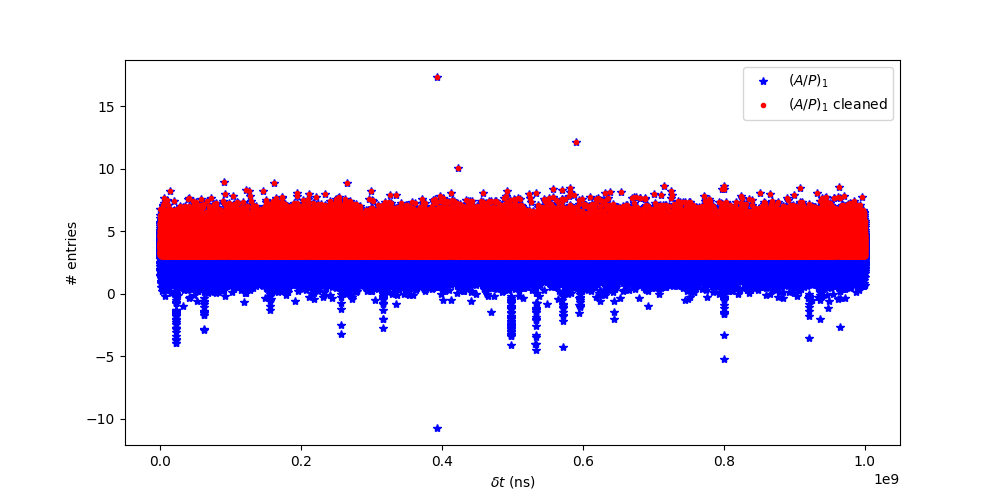

Text(0.5, 0, '$\\delta t$ (ns)')

In [ ]:
fig,ax=plt.subplots(figsize=(10,5))
#h1,b1=np.histogram(p,bins=100,density=1)
#ax.semilogy(b1[:-1],h1,'r*',lw=2,label='Diferencia temporal')
ax.plot(dt*TIME_SEP*1e9,ap_1,'b*',label=r'$(A/P)_1$')
ax.plot(dt_clean*TIME_SEP*1e9,ap_clean,'r.',label=r'$(A/P)_1$ cleaned')
#ax[1].plot(dt*TIME_SEP*1e9,a2/p2,'b.',label=r'$(A/P)_2$')
#ax.plot(ap_clean,'r.',label=r'$(A/P)_1$')
#ax[1].plot([int(dt[i]*TIME_SEP*1e6) for i in range(len(dt))],a2/p2,'b.',label=r'$(A/P)_2$')
#ax[1].plot(dt[:10]*TIME_SEP,a2[:10]/p2[:10],'b.',label=r'$(A/P)_2$')
#ax[1].plot(a2[:10]/p2[:10],dt[:10]*TIME_SEP, 'b.',label=r'$(A/P)_2$')
ax.legend()
ax.set_ylabel('# entries')
ax.set_xlabel(r'$\delta t$ (ns)')
#ax[1].set_xlabel(r'$\delta t$ (us)')
#ax[1].legend()

In [ ]:
delta_t_clean=[((dt_clean[i]-dt_clean[i-1])%125e6)*TIME_SEP for i in range(1,len(dt_clean)-1)]

<IPython.core.display.Javascript object>


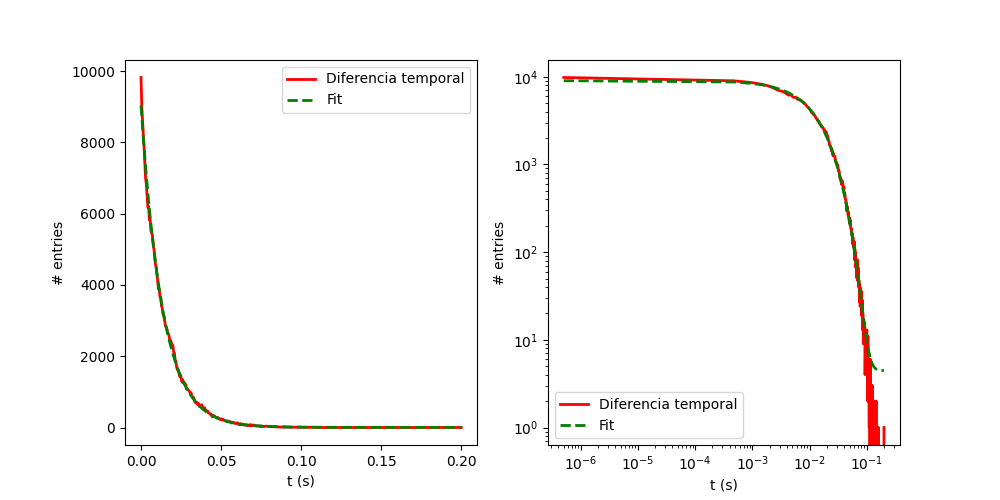

9027.63620894374 74.28724920111644 4.4658067954887395
tau = 13461.26032063348 us


In [ ]:
#xdat = np.linspace(-2, 4, 12)
#ydat = func(xdat, Adat, Bdat, Cdat) + 0.2 * np.random.normal(size=len(xdat))

#p=[((dt[i]-dt[i-1])%125e6)*TIME_SEP for i in range(1,len(dt)-1)]

h_dtc,b_dtc=np.histogram(delta_t_clean,bins='auto')
popt1,pcov1 = curve_fit(func, b_dtc[:-1], h_dtc)

fig,ax=plt.subplots(1,2,figsize=(10,5))
#ax.semilogy(b1[:-1],h1,'r*',lw=2,label='Diferencia temporal')
ax[0].plot(b_dtc[:-1],h_dtc,'r-',lw=2,label='Diferencia temporal')
ax[0].plot(b_dtc[:-1],func(b_dtc[:-1],*popt1),'g--',lw=2,label='Fit')
#ax[0].plot(b_dt[:-1],h_dt,'k-',lw=2,label='Diferencia temporal')
ax[0].set_ylabel('# entries')
ax[0].set_xlabel('t (s)')
ax[0].legend()

#fig,ax=plt.subplots(figsize=(7,6))
#ax.semilogy(b1[:-1],h1,'r*',lw=2,label='Diferencia temporal')
#ax[1].semilogy(b_dtc[:-1],h_dtc,'r-',lw=2,label='Diferencia temporal')
#ax[1].semilogy(b_dtc[:-1],func(b_dtc[:-1],*popt1),'g--',lw=2,label='Fit')
ax[1].loglog(b_dtc[:-1],h_dtc,'r-',lw=2,label='Diferencia temporal')
ax[1].loglog(b_dtc[:-1],func(b_dtc[:-1],*popt1),'g--',lw=2,label='Fit')
ax[1].set_ylabel('# entries')
ax[1].set_xlabel('t (s)')
ax[1].legend()

print(popt1[0], popt1[1], popt1[2])
print('tau = {} us'.format((1/popt1[1])*1e6))
#plt.show()

#Fin del análisis de la vida media del muon


In [ ]:
delta_t_clean=[((dt_clean[i]-dt_clean[i-1])%125e6)*TIME_SEP*1e9 for i in range(1,len(dt_clean)-1)]

/home/rarceo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>


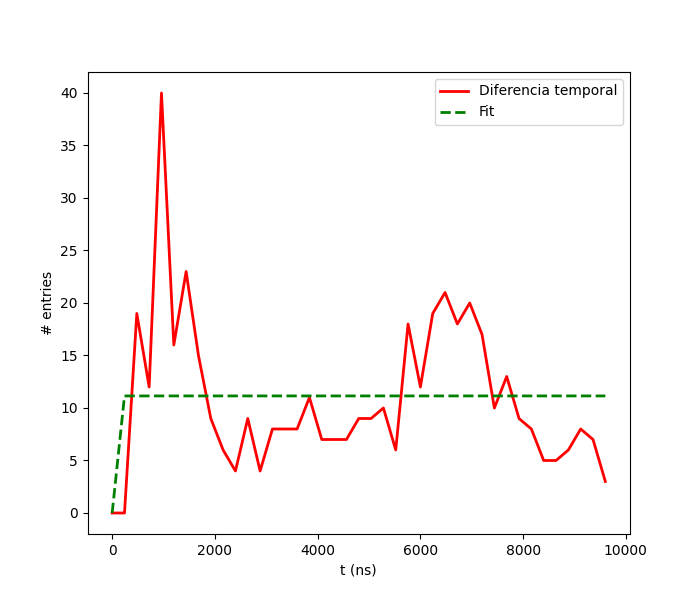

-23.34913511290787 0.739120446010537 11.149999992288816
tau = 1.35295946 s


In [ ]:
delta_t_clean=np.array(delta_t_clean)
delta_t_clean2=delta_t_clean[delta_t_clean<10000]
#h1,b1=np.histogram(p,bins=100,density=1)
h_dtc2,b_dtc2=np.histogram(delta_t_clean2,bins=np.arange(1,10000,30*8))
#h_dtc2,b_dtc2=np.histogram(delta_t_clean2,bins='auto')
popt2,pcov2 = curve_fit(func, b_dtc2[:-1], h_dtc2)

fig,ax=plt.subplots(figsize=(7,6))
#ax.semilogy(b1[:-1],h1,'r*',lw=2,label='Diferencia temporal')
ax.plot(b_dtc2[:-1],h_dtc2,'r-',lw=2,label='Diferencia temporal')
ax.plot(b_dtc2[:-1],func(b_dtc2[:-1],*popt2),'g--',lw=2,label='Fit')
#ax.loglog(b_dtc2[:-1],h_dtc2,'r-',lw=2,label='Diferencia temporal')
#ax.loglog(b_dtc2[:-1],func(b_dtc2[:-1],*popt2),'g--',lw=2,label='Fit')
#ax.plot(func(b_dtc2,34,320,140))
ax.set_ylabel('# entries')
ax.set_xlabel('t (ns)')
#plt.yscale('log')
ax.legend()

print(popt2[0], popt2[1], popt2[2])
print('tau = {:2.8f} s'.format((1/popt2[1])))